In [1]:
%load_ext autoreload
%autoreload 2   

In [2]:
import os
import sys 
from pyprojroot import here
sys.path.insert(0, str(here()))
from os.path import exists

import geopandas as gpd
from laos_gggi.data_functions import load_emdat_data, load_shapefile, load_rivers_data
from laos_gggi.plotting import configure_plot_style
from laos_gggi.statistics import get_distance_to_rivers
from laos_gggi.data_functions.combine_data import load_all_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import arviz as az
import scipy
import nutpie
import pathlib

import pymc as pm
import pytensor.tensor as pt
from laos_gggi.sample import sample_or_load

from laos_gggi.transformers import CenterTransform, Standardize

configure_plot_style()

In [3]:
def load_data(fpath):
    data = pd.read_csv(fpath)
    data['geometry'] = gpd.points_from_xy(data.long, data.lat)
    data = gpd.GeoDataFrame(data, crs='EPSG:4326')
    
    return data

folder = 'data'
modified_data = False
fpath_1 = here(os.path.join(folder, 'disaster_locations_gpt_repaired_w_features.csv'))
fpath_2 = here(os.path.join(folder, 'disaster_locations_gpt_repaired.csv'))
if os.path.exists(fpath_1):
    data = load_data(fpath_1)
elif os.path.exists(fpath_2):
    data = load_data(fpath_2)
else:
    raise ValueError('Go run the GPT notebook first!')

In [4]:
#Load data
emdat = load_emdat_data()

In [5]:
data = (data
            .set_index(['emdat_index'])
            .join(emdat['df_raw_filtered_adj'])
            .reset_index(drop=False)
            .rename(columns={'index':'emdat_index'})
            .set_index(['emdat_index', 'location_id'])
       )

In [6]:
world = load_shapefile('world')
# laos = load_shapefile('laos')

# Select Laos shape
laos = world.query('ISO_A3 == "LAO"')

# Select SEA shape
laos_neighboors = ["LAO", "VNM", "KHM", "THA"]
sea_map = world.query('ISO_A3 in @laos_neighboors')


coastline = load_shapefile('coastline')
rivers = load_rivers_data()

C:\Users\camil\AppData\Local\Temp\ipykernel_17292\3575480247.py:13: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  rivers = load_rivers_data()


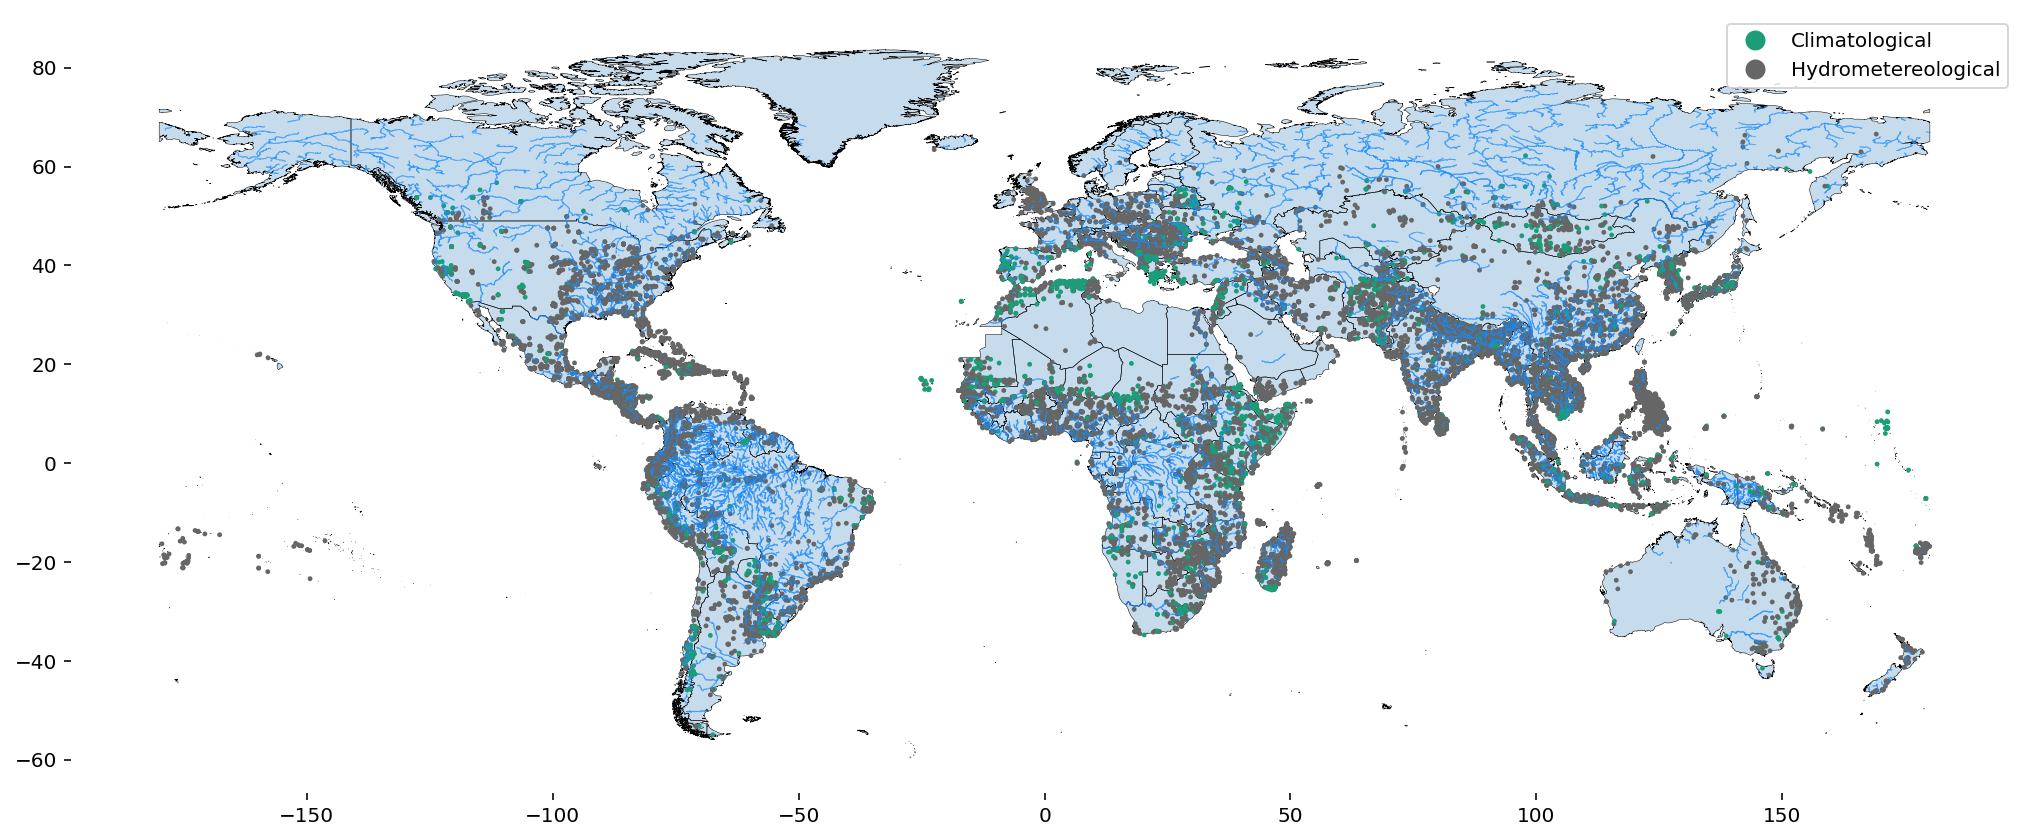

In [7]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('disaster_class', markersize=2, ax=ax, legend=True, cmap='Dark2');

In [8]:
from joblib import Parallel, delayed
import pandas as pd
from tqdm.notebook import tqdm

def get_distance_to(gdf, points, return_columns=None, crs="EPSG:3395", n_cores=-1):
    if return_columns is None:
        return_columns = []
        
    gdf_km = gdf.copy().to_crs(crs)
    points_km = points.copy().to_crs(crs)
    
    def get_closest(idx, row, gdf_km, return_columns):
        series = gdf_km.distance(row.geometry)
        index = series[series == series.min()].index[0]

        ret_vals = (series.min(), )
        for col in return_columns:
            ret_vals += (gdf_km.loc[index][col], )
        
        return ret_vals
    
    with Parallel(n_cores, require='sharedmem') as pool:
        results = pool(delayed(get_closest)(idx, row, gdf_km, return_columns) for idx, row in tqdm(points_km.iterrows(), total=points.shape[0]))
    return pd.DataFrame(results, columns = ['distance_to_closest'] + return_columns, index=points.index)

In [9]:
if 'distance_to_river' not in data.columns:
    distances = get_distance_to(rivers, points=data, return_columns=['ORD_FLOW', 'HYRIV_ID']).rename(columns={'distance_to_closest':'distance_to_river'})
    data = data.join(distances).assign(distance_to_river = lambda x: x.distance_to_river / 1000)
    modified_data = True

<Axes: ylabel='Frequency'>

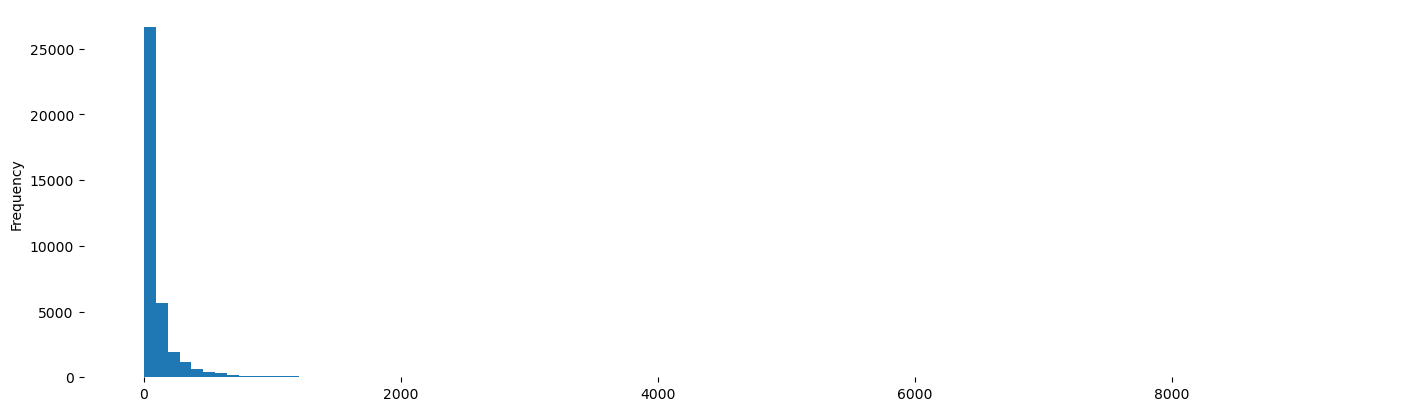

In [10]:
data.distance_to_river.plot.hist(bins=100)

In [11]:
if 'distance_to_coastline' not in data.columns:
    distances = get_distance_to(coastline.boundary, points=data.loc[:, ['geometry']]).rename(columns={'distance_to_closest':'distance_to_coastline'})
    data = data.join(distances).assign(distance_to_coastline = lambda x: x.distance_to_coastline / 1000)
    modified_data = True

<Axes: ylabel='Frequency'>

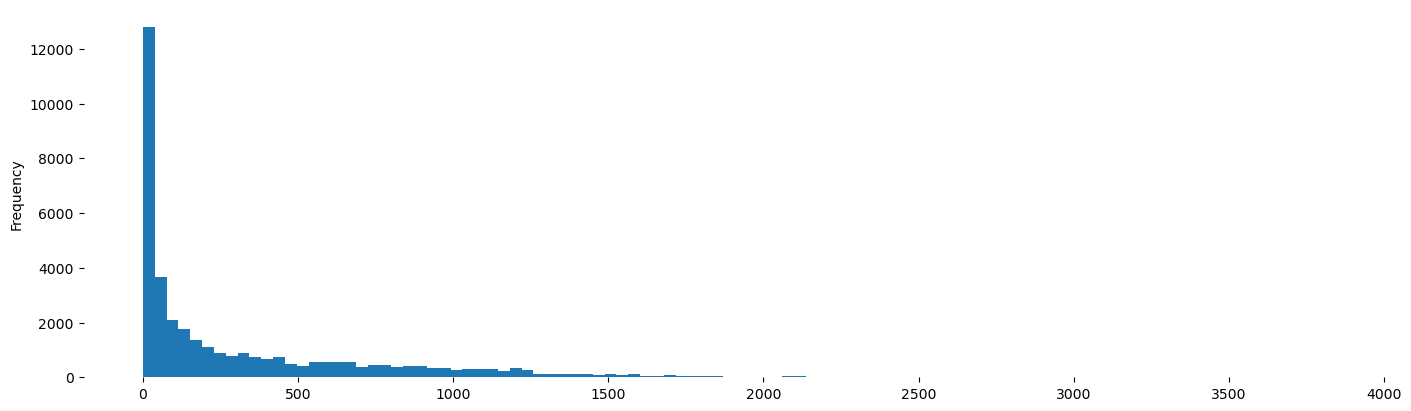

In [12]:
data.distance_to_coastline.plot.hist(bins=100)

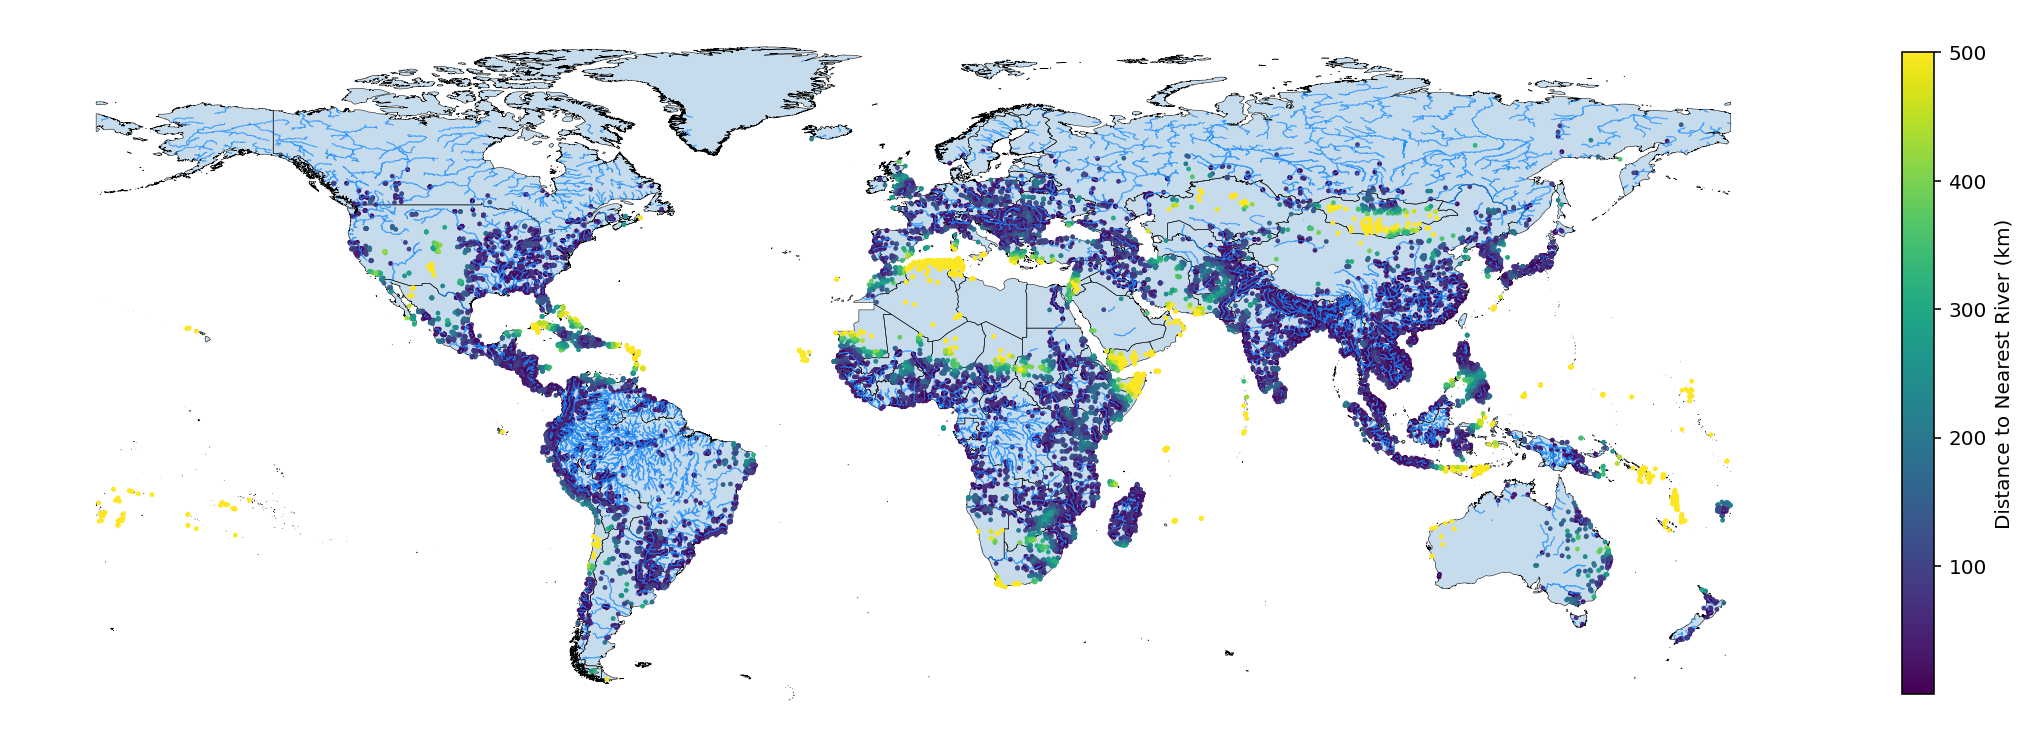

In [13]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('distance_to_river', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      cmap='viridis', 
                                      vmax=500, 
                                      legend_kwds={'shrink':0.5, 'label':'Distance to Nearest River (km)'})
ax.axis('off')
plt.show()

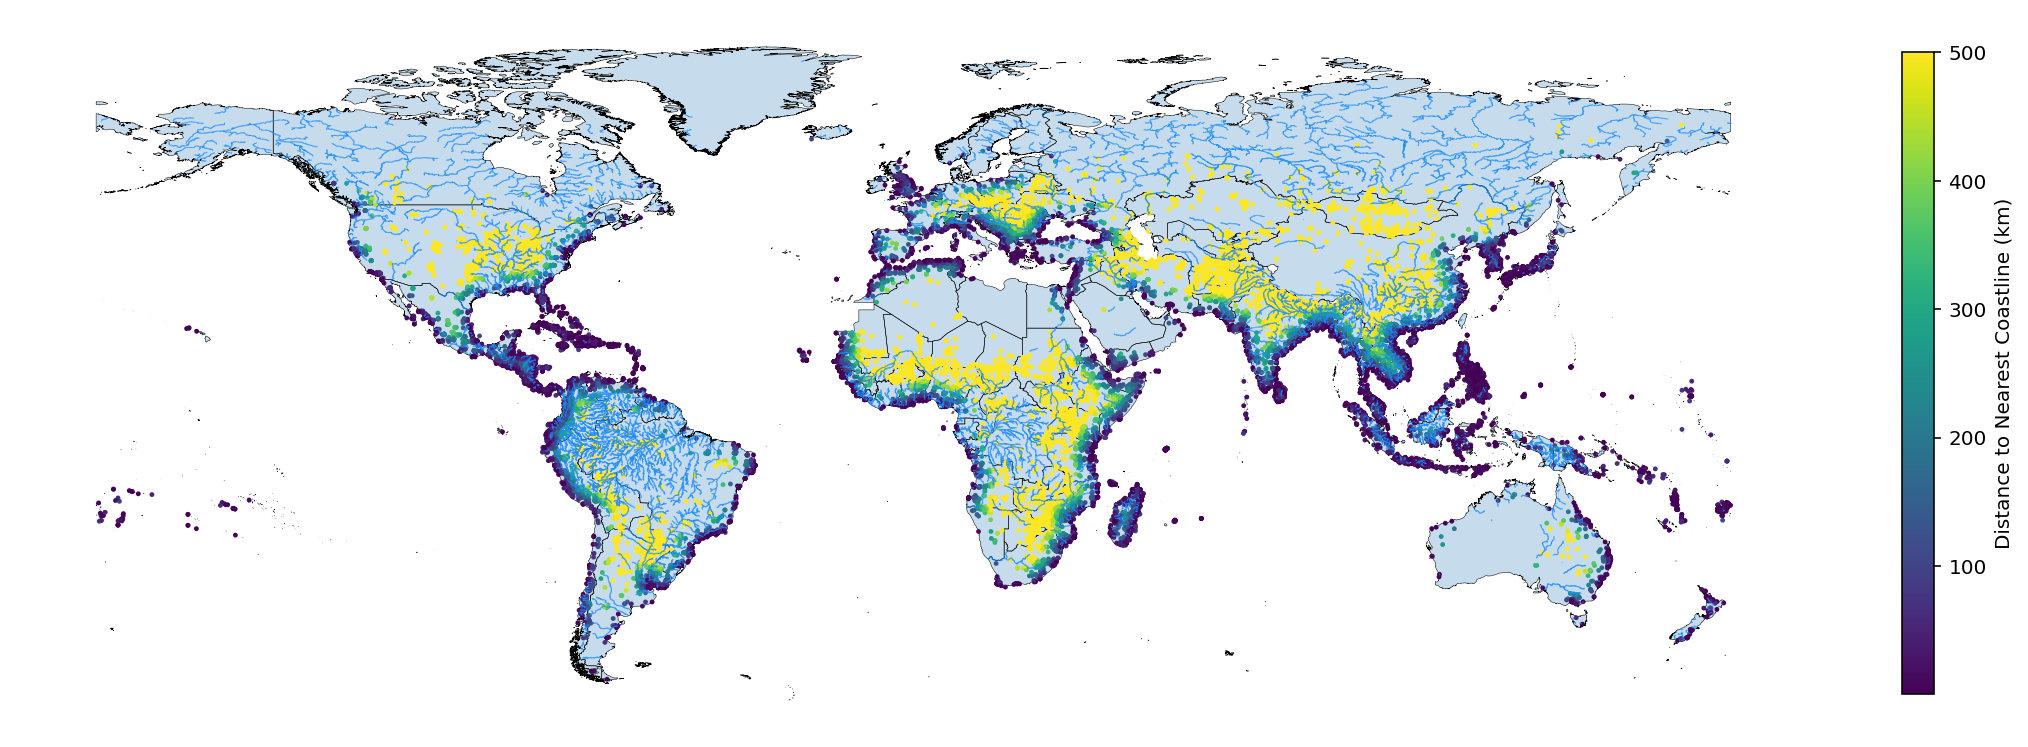

In [14]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)
data.dropna(subset='disaster_class').plot('distance_to_coastline', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      cmap='viridis', 
                                      vmax=500,
                                      legend_kwds={'shrink':0.5, 'label':'Distance to Nearest Coastline (km)'})
ax.axis('off')
plt.show()

In [15]:
if 'is_island' not in data.columns:
    try:
        import wikipedia as wp
    except ImportError:
        !mamba install wikipedia -q -y
        import wikipedia as wp

    html = wp.page("List_of_island_countries").html().encode("UTF-8")
    island_table = (pd.read_html(html, skiprows=0)[0]
                        .droplevel(axis=1, level=0)
                        .dropna(how='all').iloc[1:]
                        .reset_index(drop=True)
                        .assign(ISO_2 = lambda x: x['ISO code'].str.split().str[0],
                                ISO_3 = lambda x: x['ISO code'].str.split().str[1].replace({'or':'GBR'}))
                   )
    data['is_island'] = data.ISO.isin(island_table.ISO_3)
    modified_data = True

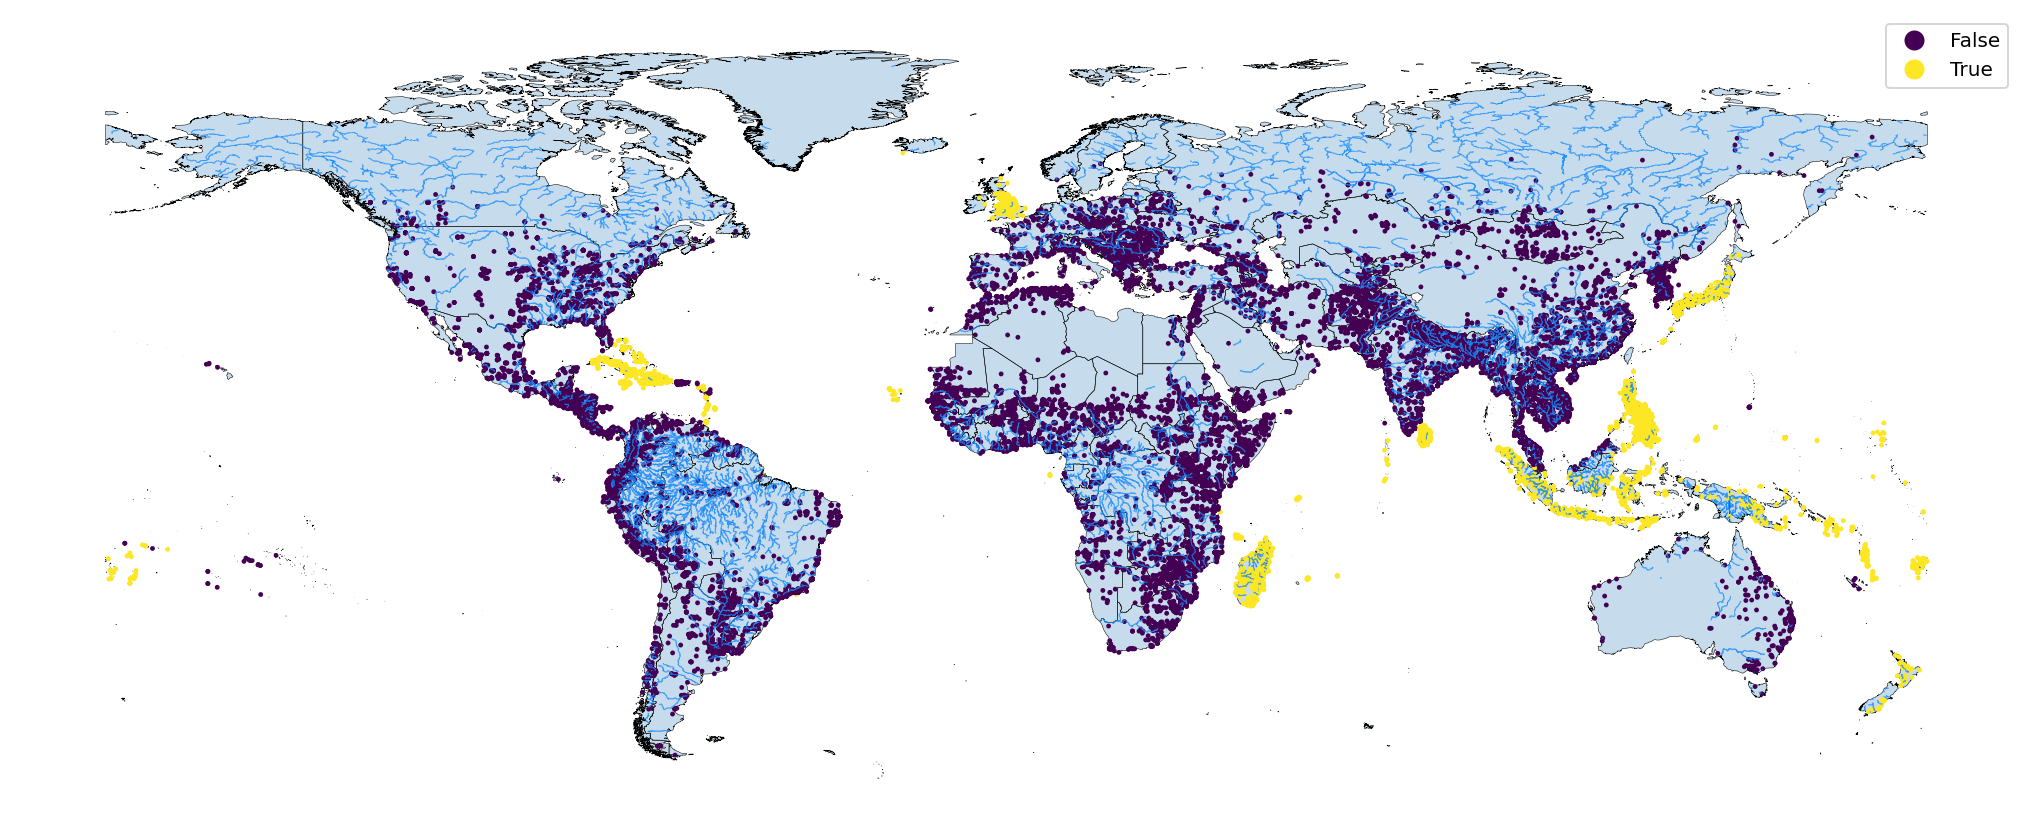

In [16]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)

data.dropna(subset='disaster_class').plot('is_island', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.show()

In [17]:
if modified_data:
    (data
         .drop(columns=emdat['df_raw_filtered_adj'].columns.tolist() + ['geometry'])
         .to_csv(fpath_1))

# Synthetic Data

Create a bunch of dummy datapoints with geospatial features. These will be non-disasters. The model will need to distinguish the real disaster data from these fake points.

In [18]:
# Loading the synthetic data by country
not_disasters = pd.read_csv(here('data/synthetic_non_disasters_by_country_long.csv'))
not_disasters['geometry'] = gpd.points_from_xy(not_disasters.long, not_disasters.lat)
not_disasters = gpd.GeoDataFrame(not_disasters, crs=data.crs)

# Merging data

In [19]:
#Rename not_disaster columns
not_disasters.rename(columns ={ "twin_emdat_index": "emdat_index",
                              "twin_location_id": "location_id"}, inplace = True)

#Assign rando years to each fake disaster
not_disasters2 = pd.merge(not_disasters, data.groupby("ISO").Start_Year.sample( frac=1.0, replace=False), right_index= True,
         left_on= ["emdat_index", "location_id" ], how = "left" )

In [20]:
#Add the is_real columns
not_disasters2["is_disaster"] = 0
data["is_disaster"] = 1

#Concat data frames
merged_df = pd.concat([not_disasters2, data.reset_index()], ignore_index= True)

In [21]:
#Load data
all_data = load_all_data()
panel_data  = all_data["df_panel"][['population_density',
       'gdp_per_cap', 'Population', 'precip']]

co2 = all_data["df_time_series"]["co2"]

In [22]:
#Obtain precip_deviation
precipitation = all_data["gpcc"]

countries = precipitation.reset_index()["ISO"].unique()

precip_deviation = pd.DataFrame()

precip_deviation = pd.DataFrame(columns=countries)
for x in countries:
    precip_deviation[x] = (
        precipitation.reset_index().pivot(
            index="year", values="precip", columns="ISO"
        )[x]
        - pd.DataFrame(precipitation.unstack(-2).head(30).mean())
        .loc["precip"]
        .loc[x]
        .values
    )

precip_deviation = (
    precip_deviation.stack()
    .reset_index()
    .rename(columns={"level_1": "ISO", 0: "precip_deviation"})
    .set_index(["ISO", "year"])
)
precip_deviation = precip_deviation.sort_index()

In [23]:
#Obtain ocean temperature deviation
from statsmodels.tsa.seasonal import STL

df_clim = all_data["df_time_series"][["co2", "Temp", "precip"]].iloc[1:-1]

stl_ocean_temp = STL(pd.DataFrame(df_clim["Temp"].dropna()), period=3)
result_ocean_temp = stl_ocean_temp.fit()
trend_ocean_temp = result_ocean_temp.trend
dev_from_trend_ocean_temp = df_clim["Temp"].dropna() - trend_ocean_temp

dev_from_trend_ocean_temp = pd.DataFrame(dev_from_trend_ocean_temp).rename(columns= {0: "dev_ocean_temp"})

In [24]:
#Merge Data Frames
merged_df2 = pd.merge(merged_df, panel_data, left_on= ["ISO", "Start_Year"], right_index= True, how = "left")
merged_df3 = pd.merge(merged_df2, co2, left_on= ["Start_Year"], right_index= True, how = "left")
merged_df4 = pd.merge(merged_df3, precip_deviation, left_on= ["ISO", "Start_Year"], right_index= True, how = "left" )
merged_df5 = pd.merge(merged_df4, dev_from_trend_ocean_temp, left_on= ["Start_Year"], right_index= True, how = "left" )

In [25]:
#preparing data set

#Creating log variables
log_list = ["distance_to_river", "distance_to_coastline", "Total_Affected", "Total_Damage_Adjusted", "population_density",
            "gdp_per_cap"]
for y in log_list:
    merged_df5[f"log_{y}"] = np.log(merged_df5[y])


#Creating the squared log variables
merged_df5["log_population_density_squared"] = 2 *merged_df5["log_population_density"]
merged_df5["log_gdp_per_cap_squared"] = 2 * merged_df5["log_gdp_per_cap"]

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
model_list = ["Population", "co2", "precip_deviation", "dev_ocean_temp", "log_distance_to_river", 'log_distance_to_coastline',
       'log_Total_Affected', 'log_Total_Damage_Adjusted', 'log_population_density', 'log_gdp_per_cap',
       'log_population_density_squared', 'log_gdp_per_cap_squared', 
        'ISO', 'Start_Year', "is_disaster" 
             ]

model_df = merged_df5[model_list].dropna()

In [27]:
#Delimiting data set
model_list_4 = ['ISO', 'Start_Year', "is_disaster", 'distance_to_river', 'distance_to_coastline', 'is_island',
               "Population", "co2", "precip_deviation", "dev_ocean_temp", 'population_density',
               'gdp_per_cap', "lat", "long" , "geometry", "emdat_index"]

features_4 = ['log_distance_to_river', 'log_distance_to_coastline',
             "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared']

model_df_4 = merged_df5[model_list_4].dropna()

### Review of the synthetic data

We now plot the synthetic and real data 

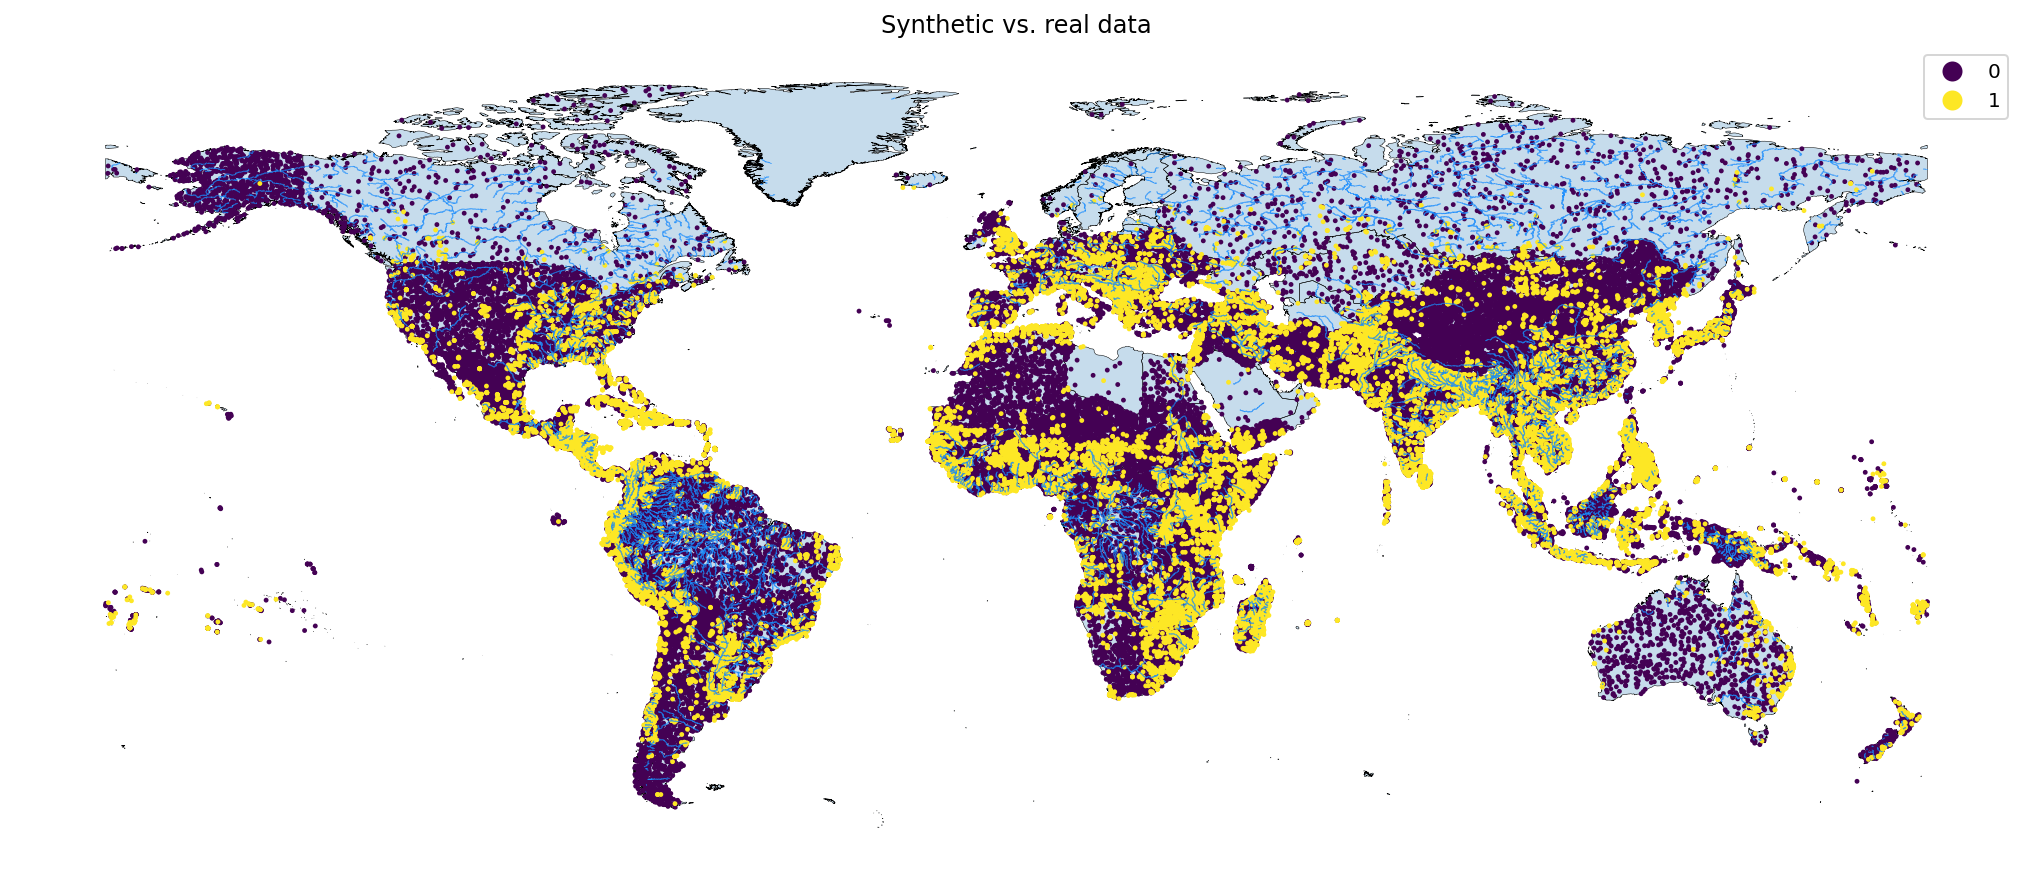

In [28]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)

merged_df5.plot('is_disaster', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.title("Synthetic vs. real data")
plt.show()

We plot the synthetic data for Lao and its neighboors. We observe there is a lack of synthetic data for them

In [29]:
laos_neighboors_df = model_df_4.query('ISO in @laos_neighboors')

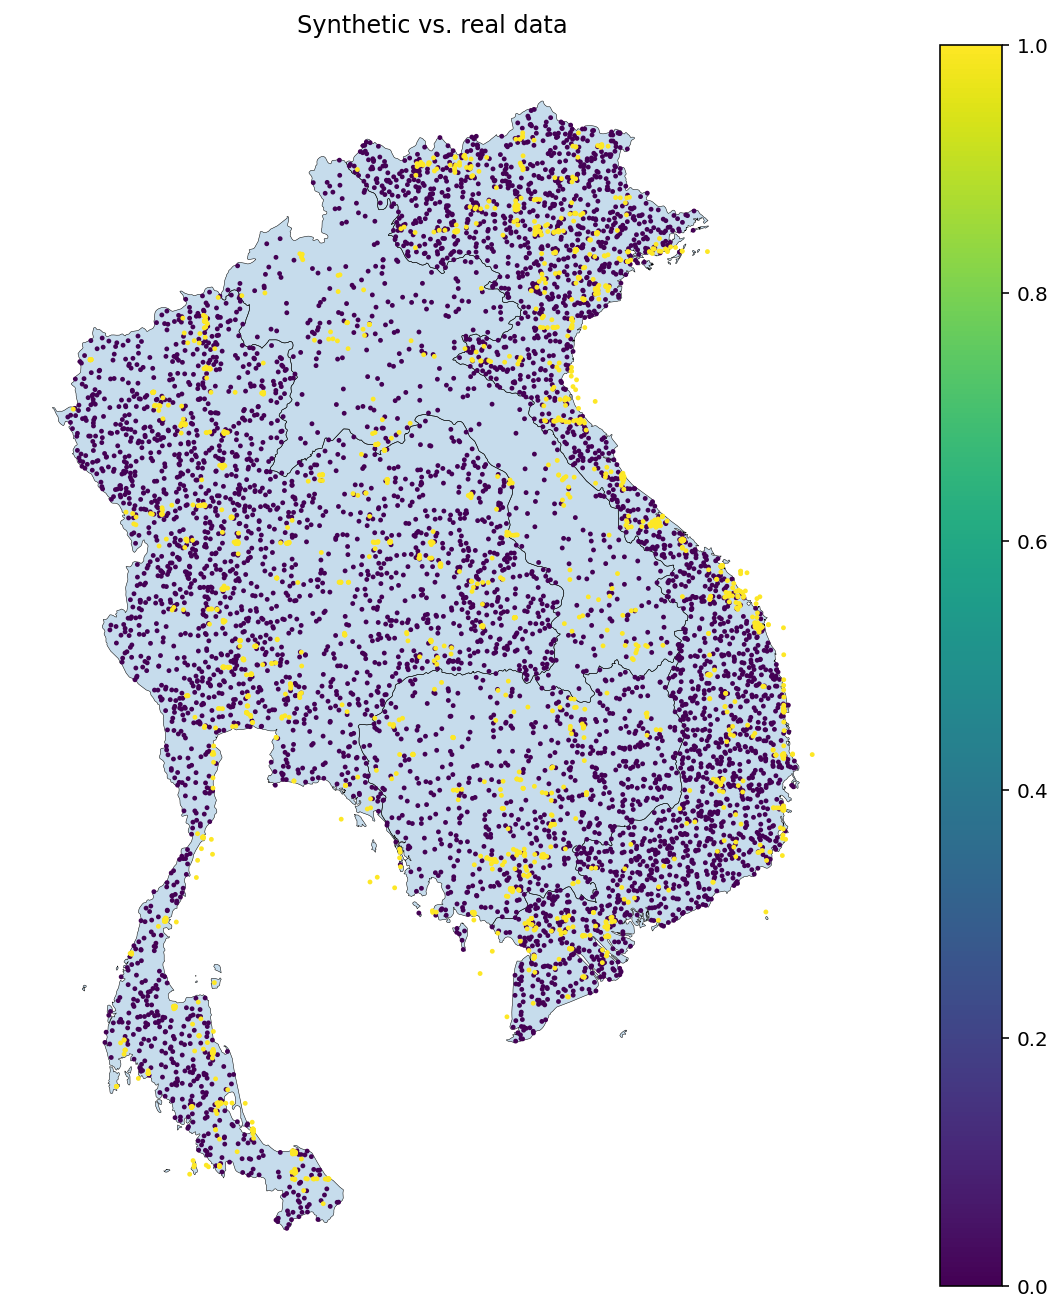

In [30]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.query('ISO_A3 in @laos_neighboors ').plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.query('ISO_A3 in @laos_neighboors ').plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
# rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)

laos_neighboors_df.plot('is_disaster', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      # categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.title("Synthetic vs. real data")
plt.show()

In [31]:
pd.merge(laos_neighboors_df.query('is_disaster == 0').value_counts("ISO"),
         laos_neighboors_df.query('is_disaster == 1').value_counts("ISO"), left_index=True, right_index=True).rename(
    columns = {"count_x": 'no_disaster', "count_y": "disaster"}
         )

no_disaster  disaster
ISO                       
VNM         2484       828
THA         2310       770
KHM          567       189
LAO          300       100

# Model helper functions

In [32]:
#Define data function
def add_data(features: list[str], target: str, df: pd.DataFrame , add_time :bool = False):
    
    with pm.modelcontext(None):
       X = pm.Data("X", df[features], dims = ["obs_idx", "feature"] )
       Y = pm.Data("Y", df[target], dims = ["obs_idx"])
    return X,Y

#Add country fixed effect function
def add_country_effect():
  with pm.modelcontext(None):
    country_effect_mu = pm.Normal('country_effect_mu', mu = 0, sigma = 1)
    country_effect_scale = pm.Gamma('country_effect_scale', alpha=2, beta=1)
    country_effect_offset = pm.Normal('country_effect_offset', sigma=1, dims="ISO")
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_scale * country_effect_offset, dims="ISO")
   
  return country_effect, country_effect_mu, country_effect_scale, country_effect_offset


In [33]:
# Function to create plot inputs
def generate_plot_inputs(idata):
    #Extract predictions
    predictions = idata.posterior_predictive['y_hat'].mean(dim=['chain', 'draw'])
    predictions = predictions.to_dataframe().drop(columns = ["ISO"]).reset_index().rename(columns = {"y_hat": "predictions"})

    hdi_mean = az.hdi(idata.posterior_predictive.y_hat)

    hdi = hdi_mean['y_hat'].to_dataframe().drop(columns = ["ISO"]).reset_index()

    hdi_mean_50 = az.hdi(idata.posterior_predictive.y_hat, hdi_prob=.5)
    
    hdi_50 = hdi_mean_50['y_hat'].to_dataframe().drop(columns = ["ISO"]).reset_index()

    #Merge results and predictions in one df
    df_predictions = df[[ "ISO"]]

    #95% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi.query('hdi == "lower"')[["ISO", "y_hat"]] , 
             left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_95"}))
    df_predictions = (pd.merge(df_predictions, hdi.query('hdi == "higher"')[["ISO",  "y_hat"]] ,
         left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_95"}))
    #50% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi_50.query('hdi == "lower"')[["ISO",  "y_hat"]] , 
             left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_50"}))
    df_predictions = (pd.merge(df_predictions, hdi_50.query('hdi == "higher"')[["ISO", "y_hat"]] ,
         left_on= ["ISO"], right_on= ["ISO"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_50"}))
    
    #Predictions
    df_predictions = (pd.merge(df_predictions, predictions ,
             left_on= ["ISO"], right_on= ["ISO"], how = "left")
             .rename(columns = {"y_hat": "predictions"}))
    
    return df_predictions

In [34]:
#Plotting function
def plotting_function(idata, country: str):
    df_predictions = generate_plot_inputs(idata = idata)

    #Filter country
    data = df_predictions.query("ISO == @country")
    
    fig, ax = plt.subplots()
    ax.plot(data["year"], data["predictions"], zorder=1000, color='tab:red', label='Mean Predicted Disaster Count')
    ax.scatter(data["year"], data["is_disaster"], color='k', label='Actual prob')
    ax.fill_between(data["year"], data["higher_y_hat_95"], data["lower_y_hat_95"], alpha=0.25, color='tab:blue', label='95% HDI')
    ax.fill_between(data["year"], data["lower_y_hat_50"], data["higher_y_hat_50"], alpha=0.5, color='tab:blue', label='50% HDI')
    ax.legend(loc='upper left')

    #plt.title(f"{country} disaster count and predictions")

    plt.xlabel("Year")
    plt.ylabel("Disaster Count")
    
    plt.show();
    

In [35]:
def plot_ppc_loopit(idata, title):
    fig = plt.figure(figsize=(12,9))
    ax_ppc = fig.add_subplot(211)
    ax1 = fig.add_subplot(223); ax2 = fig.add_subplot(224)
    az.plot_ppc(idata, ax=ax_ppc);
    for ax, ecdf in zip([ax1, ax2], (False, True)):
        az.plot_loo_pit(idata, y="y_hat", ecdf=ecdf, ax=ax);
    ax_ppc.set_title(title)
    ax_ppc.set_xlabel("")
    return np.array([ax_ppc, ax1, ax2])

# Creating Laos grid

In [36]:
if exists(here("data/laos_points.shp")):
    laos_points = gpd.read_file(here("data/laos_points.shp"))
    laos_points = laos_points.rename(columns = {"distance_t": "distance_to_river",
                           "distance_1": "distance_to_coastline",
                           "log_distan": "log_distance_to_river",
                           "log_dist_1": "log_distance_to_coastline",
                          })

else:    
    #Creating Laos grid
    lon_min, lat_min, lon_max, lat_max = laos.dissolve().bounds.values.ravel()
    lon_grid = np.linspace(lon_min, lon_max, 100)
    lat_grid = np.linspace(lat_min, lat_max, 100)
    
    laos_grid = np.column_stack([x.ravel() for x in np.meshgrid(lon_grid, lat_grid)])
    grid = gpd.GeoSeries(gpd.points_from_xy(*laos_grid.T), crs='EPSG:4326')
    grid = gpd.GeoDataFrame({'geometry': grid})
    
    laos_points = grid.overlay(laos, how='intersection').geometry
    laos_points = laos_points.to_frame().assign(lon = lambda x: x.geometry.x, lat = lambda x: x.geometry.y)
    
    
    # Obtain distance with rivers
    Laos_distances_rivers = (get_distance_to(rivers, points=laos_points, return_columns=['ORD_FLOW', 'HYRIV_ID'])
                      .rename(columns={'distance_to_closest':'distance_to_river'}))
    
    laos_points = pd.merge(laos_points, Laos_distances_rivers, left_index= True, right_index= True, how = "left")
    
    
    #Obtain Laos distance with coastlines
    Laos_distances_coastlines = (get_distance_to(coastline.boundary, points=laos_points, return_columns=None)
                                  .rename(columns={'distance_to_closest':'distance_to_coastline'}))
    
    laos_points =  pd.merge(laos_points, Laos_distances_coastlines, left_index= True, right_index= True, how = "left")
    
    #Assign is_island column
    laos_points["is_island"] = False
    
    #Create log of distances
    laos_points = laos_points.assign(log_distance_to_river = lambda x: np.log(x.distance_to_river)  )
    
    laos_points = laos_points.assign(log_distance_to_coastline = lambda x: np.log(x.distance_to_coastline)  )
    
    laos_points.to_file(here("data/laos_points.shp"))

# Creating sea grid

In [37]:
if exists(here("data/sea_points.shp")):
    sea_points = gpd.read_file(here("data/sea_points.shp"))
    sea_points = sea_points.rename(columns = {"distance_t": "distance_to_river",
                           "distance_1": "distance_to_coastline",
                           "log_distan": "log_distance_to_river",
                           "log_dist_1": "log_distance_to_coastline",
                          })

else:    
    lon_min_sea, lat_min_sea, lon_max_sea, lat_max_sea = sea_map.dissolve().bounds.values.ravel()
    lon_grid_sea = np.linspace(lon_min_sea, lon_max_sea, 400)
    lat_grid_sea = np.linspace(lat_min_sea, lat_max_sea, 400)
    
    sea_grid = np.column_stack([x.ravel() for x in np.meshgrid(lon_grid_sea, lat_grid_sea)])
    grid_sea = gpd.GeoSeries(gpd.points_from_xy(*sea_grid.T), crs='EPSG:4326')
    grid_sea = gpd.GeoDataFrame({'geometry': grid_sea})
    
    sea_points = grid_sea.overlay(sea_map, how='intersection').geometry
    sea_points = sea_points.to_frame().assign(lon = lambda x: x.geometry.x, lat = lambda x: x.geometry.y)
    
    #Obtain distance with rivers
    sea_distances_rivers = (get_distance_to(rivers, points=sea_points, return_columns=['ORD_FLOW', 'HYRIV_ID'])
                      .rename(columns={'distance_to_closest':'distance_to_river'}))
    
    sea_points = pd.merge(sea_points, sea_distances_rivers, left_index= True, right_index= True, how = "left")
    
    
    #Obtain sea distance with coastlines
    sea_distances_coastlines = (get_distance_to(coastline.boundary, points=sea_points, return_columns=None)
                                  .rename(columns={'distance_to_closest':'distance_to_coastline'}))
    
    sea_points =  pd.merge(sea_points, sea_distances_coastlines, left_index= True, right_index= True, how = "left")
    
    #Assign is_island column
    sea_points["is_island"] = False
    
    #Create log of distances
    sea_points = sea_points.assign(log_distance_to_river = lambda x: np.log(x.distance_to_river)  )
    
    sea_points = sea_points.assign(log_distance_to_coastline = lambda x: np.log(x.distance_to_coastline)  )
    
    sea_points.to_file(here("data/sea_points.shp"))

# Losgistic regression with HSGP component

In [38]:
#Delimiting data set
model_list_4 = ['ISO', 'Start_Year', "is_disaster", 'log_distance_to_river', 'log_distance_to_coastline', 'is_island',
               "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
               'log_gdp_per_cap', 'log_gdp_per_cap_squared', "lat", "long" ]

features_4 = ['log_distance_to_river', 'log_distance_to_coastline',
             "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared']

model_df_4 = merged_df5[model_list_4].dropna()

In [39]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_4["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_4["ISO"]) 
obs_idx = model_df_4.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_4.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_4 = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_4,
        "gp_feature":gp_features }
 

## 100% Sample m=15

In [40]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_4["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_4["ISO"]) 
obs_idx = model_df_4.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_4.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_4_sample = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_4,
        "gp_feature":gp_features }


In [41]:
with pm.Model(coords=coords_4_sample) as model_distance4:
    #Declare data
    X, Y= add_data(features= features_4 ,  target = "is_disaster", df =  model_df_4, )
    is_island = pm.Data("is_island",  model_df_4["is_island"].astype(bool), dims = ["obs_idx"] )
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [0.1] * 10
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", model_df_4[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2.0)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 15, 15, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))

    #Model mu
    p = country_effect[ISO_idx] + (X * beta).sum(axis=1) + (is_island * is_island_beta) + HSGP_component

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [42]:
from pymc.model.transform.optimization import freeze_dims_and_data

if exists("full_sample_m15_long_non-dis_idata.idata"):
    model_distance4_idata = az.from_netcdf("full_sample_m15_long_non-dis_idata.idata")


else:
    compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(model_distance4), backend="jax", gradient_backend='jax')
    model_distance4_idata = nutpie.sample(compiled_model)
    #Rename the is_island variable 
    model_distance4_idata = model_distance4_idata.rename({"'is_island'": "is_island_beta"})
    #Save the idata
    az.to_netcdf(data = model_distance4_idata, filename= pathlib.Path("full_sample_m15_long_non-dis_idata.idata"))
    

az.summary(model_distance4_idata, var_names=[ 'beta', "is_island_beta", 'eta', 'ell'])

az.plot_trace(model_distance4_idata, var_names=[ 'beta', "is_island_beta", 'eta', 'ell']);

### Laos prediction

### HSGP component

In [43]:
#HSGP component
laos_grid_2d = np.array(laos_points[["lat", "lon"]])

with pm.Model(coords=coords_4) as HSGP_m_15_plot:
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=laos_grid_2d)
    
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))
    f_plot_invlogit = pm.Deterministic('f_plot_invlogit', pm.math.invlogit(f_plot))

    HSGP_m_15_plot_idata = pm.sample_posterior_predictive(
        model_distance4_idata, var_names=["f_plot","f_plot_invlogit"]
    )
    

Sampling: []


Output()

In [44]:
#Store df of predictions
model_distance_HSGP_predictions = (HSGP_m_15_plot_idata.posterior_predictive.mean(dim=("chain", "draw"))
                               ["f_plot_invlogit"]
                               .to_dataframe())

#Merge predictions with Laos points
model_distance_HSGP_predictions = pd.merge(model_distance_HSGP_predictions, laos_points, 
                                       left_index=True, right_index=True,
                                       how = "left")

#Transform into geo Data Frame
model_distance_HSGP_predictions_geo = gpd.GeoDataFrame(
                model_distance_HSGP_predictions,
    geometry=gpd.points_from_xy(model_distance_HSGP_predictions["lon"], model_distance_HSGP_predictions["lat"]), crs="EPSG:4326"
            )



In [45]:
#Create the geodata set for Laos disasters
laos_disasters = model_df_4.query('ISO == "LAO" & is_disaster == 1')

laos_disasters_geo = gpd.GeoDataFrame(
                laos_disasters,
    geometry=gpd.points_from_xy(laos_disasters["long"], laos_disasters["lat"]), crs="EPSG:4326"
            )

#Plot the predictions
fig, ax = plt.subplots()
model_distance_HSGP_predictions_geo.plot("f_plot_invlogit",legend=True, ax=ax)
plt.title("HSGP for Laos", );

model_df_4.query('ISO == "LAO" & is_disaster == 1')

#Plot predictions with actual disasters
fig, ax = plt.subplots()
model_distance_HSGP_predictions_geo.plot("f_plot_invlogit",legend=True, ax=ax)

laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "#fc3468")
plt.title("Predictions of the probability of disaster for Laos", )
;

### Full model predictions

az.summary(model_distance4_idata, var_names=["beta"])

In [46]:
#Full model predictions
laos_grid_2d = np.array(laos_points[["lat", "lon"]])

time_varying_features_4 = ['Population','co2','precip_deviation','dev_ocean_temp','log_population_density',
                            'log_population_density_squared','log_gdp_per_cap','log_gdp_per_cap_squared']


with pm.Model(coords=coords_4) as full_model_m_15_plot:
    #Declare data
    laos_is_island = laos_points["is_island"]
    laos_distances = laos_points[["log_distance_to_coastline", "log_distance_to_river"]]
    time_varying_features_2020 =(model_df_4.loc[70736,][time_varying_features_4]).astype(float)

    #Flat variables
    is_island_beta = pm.Flat("is_island_beta")
    beta = pm.Flat("beta", dims = ["feature"])
    country_effect = pm.Flat("country_effect", dims = ["ISO"])
    
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=laos_grid_2d)
    
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))
    
    
    point_prediction = pm.Deterministic("point_prediction", 
                            country_effect[128] 
                            + ( is_island_beta * laos_is_island) 
                            #+ (beta[0] * laos_distances["log_distance_to_river"] ) + (beta[1] * laos_distances["log_distance_to_coastline"])
                            + f_plot
                            #+  (beta[2:] @ time_varying_features_2020 )
                              )
    
    point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

    full_model_m_15_plot_idata = pm.sample_posterior_predictive(
        model_distance4_idata, var_names= ["point_probability"]
    )
    

Sampling: []


Output()

In [47]:
#Store df of predictions
full_model_m_15_plot_idata_predictions = (full_model_m_15_plot_idata.posterior_predictive.mean(dim=("chain", "draw"))
                               ["point_probability"]
                               .to_dataframe())

#Merge predictions with Laos points
full_model_m_15_plot_idata_predictions = pd.merge(full_model_m_15_plot_idata_predictions, laos_points, 
                                       left_index=True, right_index=True,
                                       how = "left")

#Transform into geo Data Frame
full_model_m_15_plot_idata_predictions_geo = gpd.GeoDataFrame(
                full_model_m_15_plot_idata_predictions,
    geometry=gpd.points_from_xy(full_model_m_15_plot_idata_predictions["lon"],
                                full_model_m_15_plot_idata_predictions["lat"]),crs="EPSG:4326"
            )



#Plot the predictions
fig, ax = plt.subplots()
full_model_m_15_plot_idata_predictions_geo.plot("point_probability",legend=True, ax=ax)
plt.title("Model prediction for Laos", );

#Plot predictions with actual disasters
fig, ax = plt.subplots()
model_distance_HSGP_predictions_geo.plot("f_plot_invlogit",legend=True, ax=ax)

laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "#fc3468",markersize =5 )
plt.title("Predictions of the probability of disaster for Laos", )
;

# Estimation for southeast Asia only: HSGP

In [48]:
#We define the map and the df for south east asia
sea_df = model_df_4.query('ISO in @laos_neighboors')

#Tranform to geopandas df
sea_df = gpd.GeoDataFrame(sea_df,  geometry=gpd.points_from_xy(sea_df["long"],
                                sea_df["lat"]),crs="EPSG:4326")

To avoid centering problems, we need to have the same center values for `lat` and `long` in the `sea_df` and `sea_points` data frames.

In [49]:
print("Center for sea_df:")
print((sea_df[["lat", "long"]].max() - sea_df[["lat", "long"]].min() ) / 2)

print("-----------------------")

print("Center for sea_points:")
print((sea_points[["lat", "lon"]].max() -  sea_points[["lat", "lon"]].min()) /2)

Center for sea_df:
lat     8.791517
long    6.040052
dtype: float64
-----------------------
Center for sea_points:
lat    8.823740
lon    6.030132
dtype: float64


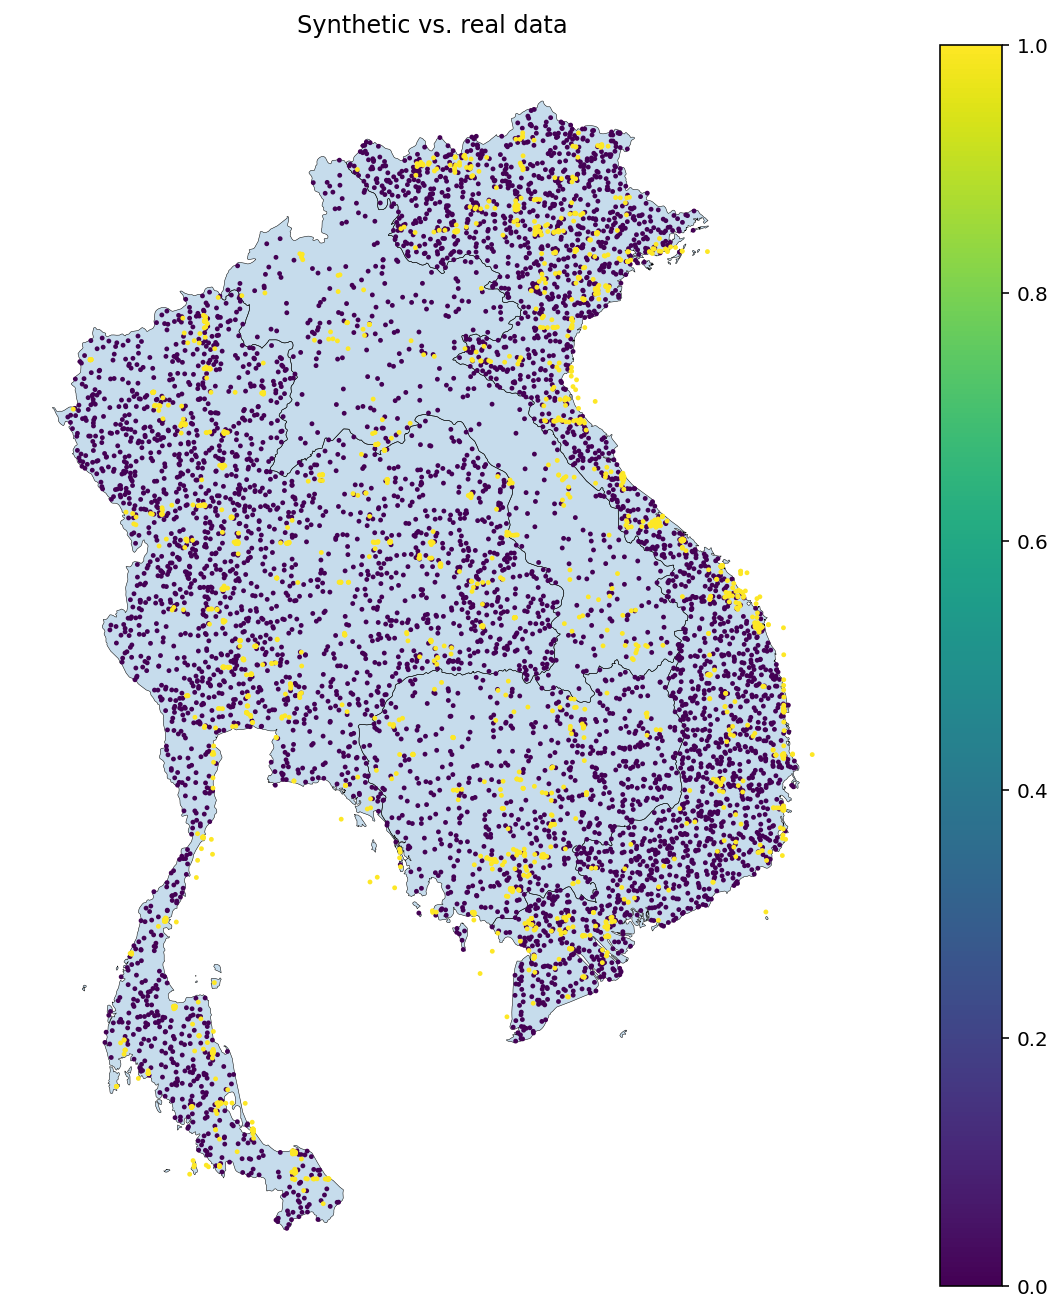

In [50]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.query('ISO_A3 in @laos_neighboors ').plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.query('ISO_A3 in @laos_neighboors').plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
# rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)

sea_df.plot('is_disaster', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      # categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.title("Synthetic vs. real data")
plt.show()

In [51]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(sea_df["is_disaster"])
ISO_idx, ISO = pd.factorize(sea_df["ISO"]) 
obs_idx = sea_df.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(sea_df.set_index(['ISO', 'Start_Year']).index, 'obs_idx')



# Standardize data
transformer_stand_ =  Standardize().fit(sea_df)
sea_df_stand = transformer_stand_.transform(sea_df)

features_4_stand = []
for feature in features_4:
    features_4_stand.append(feature + "__standardized" )

#Set coords
coords_sea = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_4_stand,
        "gp_feature":gp_features }


In [52]:
time_varying_features_4 = ['Population','co2','precip_deviation','dev_ocean_temp','log_population_density',
                            'log_population_density_squared','log_gdp_per_cap','log_gdp_per_cap_squared']
time_varying_features_4_stand = []

for feature in time_varying_features_4:
    time_varying_features_4_stand.append(feature + "__standardized")

In [53]:
with pm.Model(coords=coords_sea) as model_sea_1_hsgp:
    #Declare data
    X, Y= add_data(features= features_4_stand ,  target = "is_disaster", df =  sea_df_stand, )
    is_island = pm.Data("is_island",  sea_df_stand["is_island"].astype(bool), dims = ["obs_idx"] )
    
    # #Country effect
    # country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    # beta_sigma = [0.1] * 10
    # beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    # is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", sea_df[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 15, 15, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))


    #Model mu
    # p = (
    #     #country_effect[ISO_idx] + 
    #     (X * beta).sum(axis=1) + (is_island * is_island_beta) + HSGP_component)
    p = HSGP_component
    

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [54]:
if exists("model_sea_HSGP.idata"):
    model_sea_1_hsgp_idata = az.from_netcdf("model_sea_HSGP.idata")


else:
    compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(model_sea_1_hsgp), backend="jax", gradient_backend='jax')
    model_sea_1_hsgp_idata = nutpie.sample(compiled_model)
    #Rename the is_island variable 
    model_sea_1_hsgp_idata = model_sea_1_hsgp_idata.rename({"'is_island'": "is_island_beta"})
    #Save the idata
    az.to_netcdf(data = model_sea_1_hsgp_idata, filename= pathlib.Path("model_sea_HSGP.idata"))

In [55]:
# HSGP predictions
# sea_grid_2d_basis = transformer__center.transform(sea_points[["lat", "lon"]].rename(columns = {"lon": "long"}))
sea_grid_2d = np.array(sea_points[["lat", "lon"]])

with pm.Model(coords=coords_sea) as model_sea_hsgp_plot:
    #Declare data
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=sea_grid_2d)
    
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))
    

    point_prediction =  pm.Deterministic("point_prediction", f_plot)
    
    point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

    model_sea_hsgp_plot_idata = pm.sample_posterior_predictive(
        model_sea_1_hsgp_idata, var_names= ["point_prediction", "point_probability"]
    ) 

Sampling: []


Output()

In [56]:
#Store df of predictions
model_sea_hsgp_idata_predictions = {}
model_sea_hsgp_idata_predictions_geo = {}
for x in ["point_prediction", "point_probability"]:
    
    model_sea_hsgp_idata_predictions[x] = (model_sea_hsgp_plot_idata.posterior_predictive.mean(dim=("chain", "draw"))
                                   [x]
                                   .to_dataframe())
    
    #Merge predictions with Laos points
    model_sea_hsgp_idata_predictions[x] = pd.merge(model_sea_hsgp_idata_predictions[x], sea_points, 
                                           left_index=True, right_index=True,
                                           how = "left")
    
    #Transform into geo Data Frame
    model_sea_hsgp_idata_predictions_geo[x] = gpd.GeoDataFrame(
                    model_sea_hsgp_idata_predictions[x],
        geometry=gpd.points_from_xy(model_sea_hsgp_idata_predictions[x]["lon"],
                                    model_sea_hsgp_idata_predictions[x]["lat"]),crs="EPSG:4326"
                )

In [57]:
#Create the geodata set for sea disasters
sea_disasters = model_df_4.query('ISO in @laos_neighboors & is_disaster == 1')

sea_disasters_geo = gpd.GeoDataFrame(
                sea_disasters,
    geometry=gpd.points_from_xy(sea_disasters["long"], sea_disasters["lat"]), crs="EPSG:4326"
            )

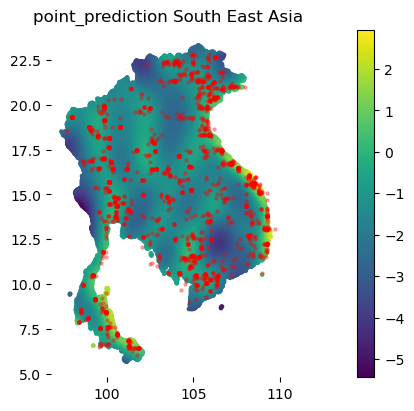

In [58]:
#Plot the predictions
fig, ax = plt.subplots()
model_sea_hsgp_idata_predictions_geo["point_prediction"].plot("point_prediction",legend=True, ax=ax,markersize =5)
sea_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_prediction South East Asia", );

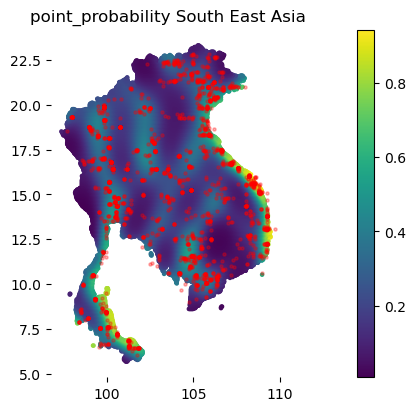

In [59]:
fig, ax = plt.subplots()
model_sea_hsgp_idata_predictions_geo["point_probability"].plot("point_probability",legend=True, ax=ax,markersize =5)
sea_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_probability South East Asia", );

# Estimation for southeast Asia only: Full model

We create the merged sea_points_extended for predictions

In [60]:
# Merge points with world ISO
sea_points_extended = gpd.sjoin(sea_points, sea_map, how="left", )

In [61]:
country_2020_data = {}
country_2020_data_df = pd.DataFrame()
for country in laos_neighboors:
    country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_4_stand + ["ISO"]]
    country_2020_data_df = pd.concat([country_2020_data_df, country_2020_data[country]])

sea_points_extended = pd.merge(sea_points_extended, country_2020_data_df, how = "left", left_on= "ISO_A3", right_on="ISO" ) 

C:\Users\camil\AppData\Local\Temp\ipykernel_17292\459676040.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_4_stand + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_17292\459676040.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_4_stand + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_17292\459676040.py:4: FutureWa

In [62]:
with pm.Model(coords=coords_sea) as model_sea_full:
    #Declare data
    X, Y= add_data(features= features_4_stand ,  target = "is_disaster", df =  sea_df_stand, )
    is_island = pm.Data("is_island",  sea_df_stand["is_island"].astype(bool), dims = ["obs_idx"] )
    
    # #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [0.1] * 10
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", sea_df[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 15, 15, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))


    #Model mu
    p = (
        country_effect[ISO_idx] + 
        (X * beta).sum(axis=1) + (is_island * is_island_beta) + HSGP_component)
    # p = HSGP_component
    

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [63]:
if exists("model_sea_full.idata"):
    model_sea_full_idata = az.from_netcdf("model_sea_full.idata")


else:
    compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(model_sea_full), backend="jax", gradient_backend='jax')
    model_sea_full_idata = nutpie.sample(compiled_model)
    #Rename the is_island variable 
    model_sea_full_idata = model_sea_full_idata.rename({"'is_island'": "is_island_beta"})
    #Save the idata
    az.to_netcdf(data = model_sea_full_idata, filename= pathlib.Path("model_sea_full.idata"))

In [64]:
#Define cooords
ISO_predict_idx, ISO_predict = pd.factorize(sea_points_extended["ISO"]) 
obs_idx_predict = sea_points_extended.index


#Set coords
coords_sea["obs_idx_predict"] = obs_idx_predict
coords_sea["ISO_predict"] = ISO_predict

In [65]:
# HSGP predictions
sea_grid_2d = np.array(sea_points_extended[["lat", "lon"]])

with pm.Model(coords=coords_sea) as model_sea_full_plot:
    #Declare data
    sea_is_island = sea_points_extended["is_island"]
    sea_distances = sea_points_extended[["log_distance_to_river__standardized", "log_distance_to_coastline__standardized"]]
    time_varying_features_2020 =np.array(sea_points_extended[time_varying_features_4_stand]).astype(float)

    #Flat variables
    is_island_beta = pm.Flat("is_island_beta")
    beta = pm.Flat("beta", dims = ["feature"])
    country_effect = pm.Flat("country_effect", dims = ["ISO"])

    # HSGP
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=sea_grid_2d)
    
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))
    

    point_prediction = pm.Deterministic("point_prediction", 
                         country_effect[ISO_predict_idx] 
                        + (is_island_beta * sea_is_island) 
                        + (beta[0] * sea_distances["log_distance_to_river__standardized"] ) + (beta[1] * sea_distances["log_distance_to_coastline__standardized"])
                        + f_plot
                        +  ( time_varying_features_2020 @ beta[2:])
                          )
    
    point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

    model_sea_full_plot_idata = pm.sample_posterior_predictive(
        model_sea_full_idata, var_names= ["point_prediction", "point_probability"]
    ) 

Sampling: []


Output()

In [66]:
#Store df of predictions
model_sea_full_predictions = {}
model_sea_full_predictions_geo = {}
for x in ["point_prediction", "point_probability"]:
    
    model_sea_full_predictions[x] = (model_sea_full_plot_idata.posterior_predictive.mean(dim=("chain", "draw"))
                                   [x]
                                   .to_dataframe())
    
    #Merge predictions with Laos points
    model_sea_full_predictions[x] = pd.merge(model_sea_full_predictions[x], sea_points, 
                                           left_index=True, right_index=True,
                                           how = "left")
    
    #Transform into geo Data Frame
    model_sea_full_predictions_geo[x] = gpd.GeoDataFrame(
                    model_sea_full_predictions[x],
        geometry=gpd.points_from_xy(model_sea_full_predictions[x]["lon"],
                                    model_sea_full_predictions[x]["lat"]),crs="EPSG:4326"
                )

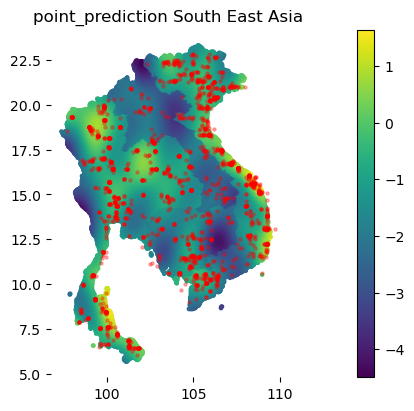

In [67]:
#Plot the predictions
fig, ax = plt.subplots()
model_sea_full_predictions_geo["point_prediction"].plot("point_prediction",legend=True, ax=ax,markersize =5)
sea_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_prediction South East Asia", );

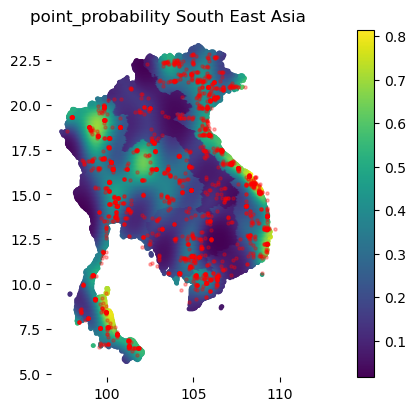

In [68]:
fig, ax = plt.subplots()
model_sea_full_predictions_geo["point_probability"].plot("point_probability",legend=True, ax=ax,markersize =5)
sea_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_probability South East Asia", );

# Estimation for Laos only: HSGP

In [69]:
#We define the map and the df for south east asia
laos_map = world.query('ISO_A3 == "LAO"')
lao_df = model_df_4.query('ISO == "LAO"')

#Tranform to geopandas df
lao_df = gpd.GeoDataFrame(lao_df,  geometry=gpd.points_from_xy(lao_df["long"],
                                lao_df["lat"]),crs="EPSG:4326")

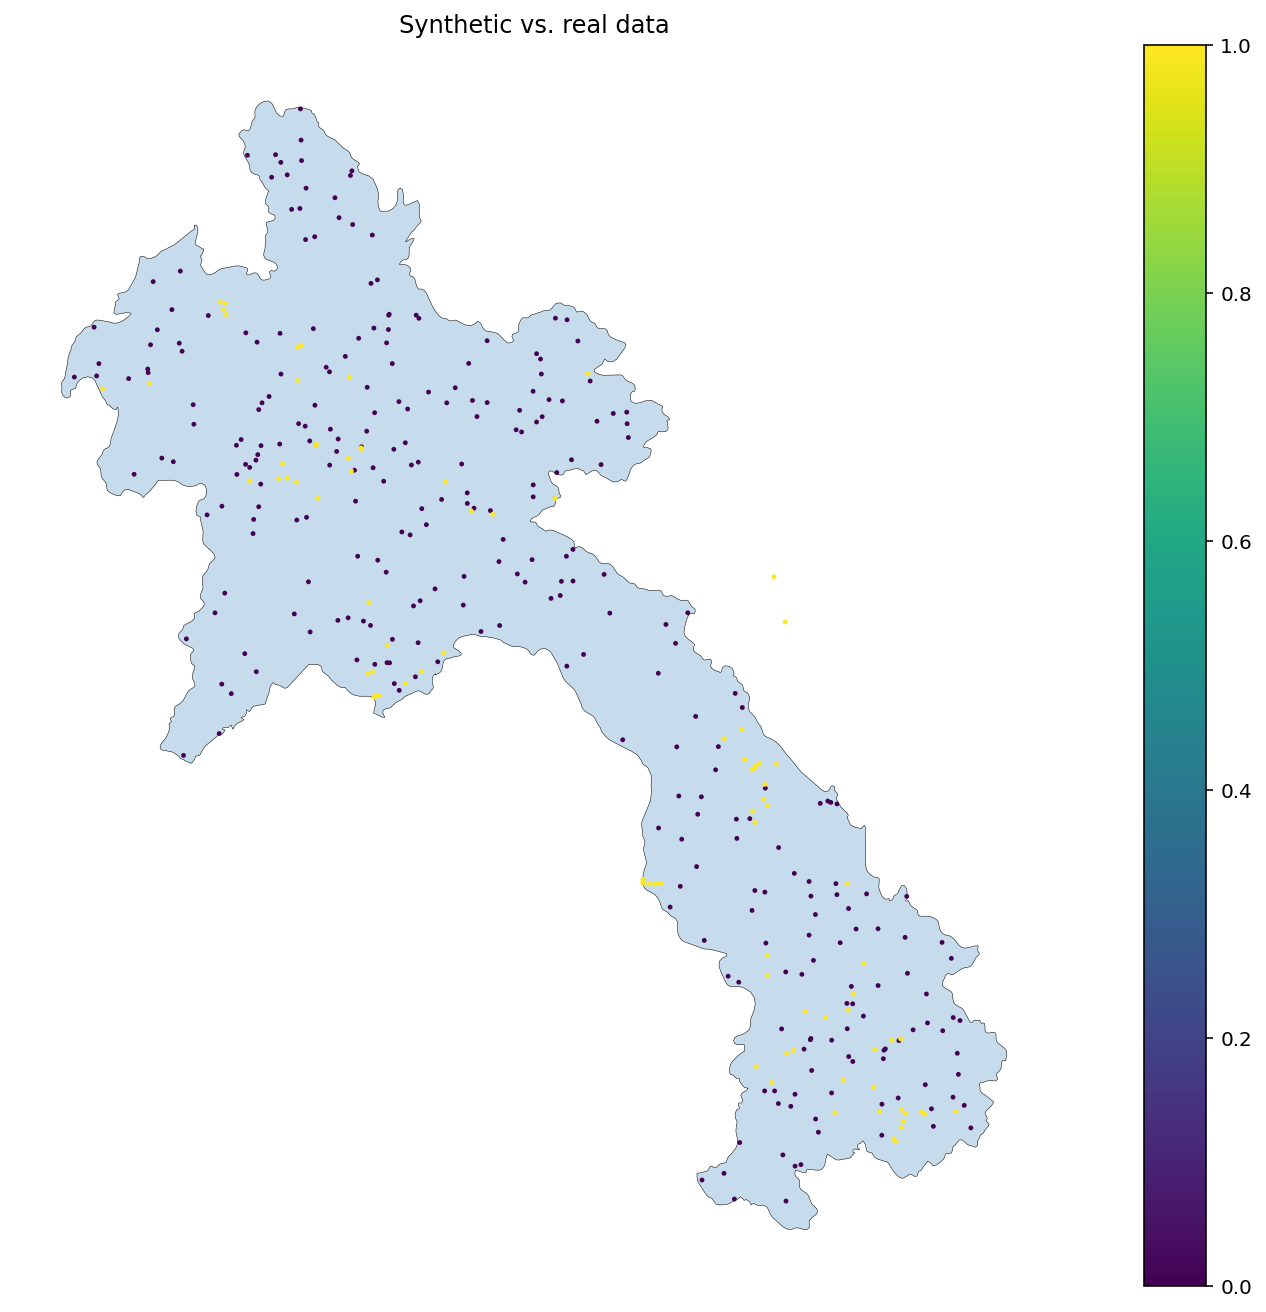

In [70]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
laos_map.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
laos_map.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)

lao_df.plot('is_disaster', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      # categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.title("Synthetic vs. real data")
plt.show()

In [71]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(lao_df["is_disaster"])
ISO_idx, ISO = pd.factorize(lao_df["ISO"]) 
obs_idx = lao_df.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(lao_df.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

# Standardize data
transformer_stand_ =  Standardize().fit(lao_df)
lao_df_stand = transformer_stand_.transform(lao_df)

# Center the lat and long variables for the HSGP
transformer__center = CenterTransform().fit(lao_df[["lat", "long"]])
centered_HSGP_data = transformer__center.transform(lao_df[["lat", "long"]])

#Set coords
coords_lao = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_4_stand,
        "gp_feature":gp_features }


In [72]:
with pm.Model(coords=coords_lao) as model_lao_1_hsgp:
    #Declare data
    X, Y= add_data(features= features_4_stand ,  target = "is_disaster", df =  lao_df_stand, )
    is_island = pm.Data("is_island",  lao_df_stand["is_island"].astype(bool), dims = ["obs_idx"] )
    
    # #Country effect
    # country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    # beta_sigma = [0.1] * 10
    # beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    # is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", centered_HSGP_data)

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2.0)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 15, 15, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))

    #Model mu
    # p = (
    #     #country_effect[ISO_idx] + 
    #     (X * beta).sum(axis=1) + (is_island * is_island_beta) + HSGP_component)
    p = HSGP_component
    

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [73]:
from pymc.model.transform.optimization import freeze_dims_and_data

if exists("model_lao_1_hsgp.idata"):
    model_lao_1_hsgp_idata = az.from_netcdf("model_lao_1_hsgp.idata")


else:
    compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(model_lao_1_hsgp), backend="jax", gradient_backend='jax')
    model_lao_1_hsgp_idata = nutpie.sample(compiled_model)
    #Rename the is_island variable 
    model_lao_1_hsgp_idata = model_lao_1_hsgp_idata.rename({"'is_island'": "is_island_beta"})
    #Save the idata
    az.to_netcdf(data = model_lao_1_hsgp_idata, filename= pathlib.Path("model_lao_1_hsgp.idata"))

In [74]:
#Full model predictions
laos_grid_2d_basis = transformer__center.transform(laos_points[["lat", "lon"]].rename(columns = {"lon": "long"}))
laos_grid_2d = np.array(laos_grid_2d_basis)


with pm.Model(coords=coords_lao) as model_lao_1_hsgp_plot:
    #Declare data
    # laos_is_island = laos_points["is_island"]
    # laos_distances = laos_points[["log_distance_to_coastline", "log_distance_to_river"]]
    # time_varying_features_2020 =(lao_df_stand.loc[18901,][time_varying_features_4_stand]).astype(float)

    # #Flat variables
    # is_island_beta = pm.Flat("is_island_beta")
    # beta = pm.Flat("beta", dims = ["feature"])
    # country_effect = pm.Flat("country_effect", dims = ["ISO"])
    
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=laos_grid_2d)
    
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))
    
    
    # point_prediction = pm.Deterministic("point_prediction", 
    #                          country_effect[0] 
    #                          + ( is_island_beta * laos_is_island) 
    #                         + (beta[0] * laos_distances["log_distance_to_river"] ) + (beta[1] * laos_distances["log_distance_to_coastline"])
    #                         + f_plot
    #                         +  (beta[2:] @ time_varying_features_2020 )
    #                           )
    point_prediction =  pm.Deterministic("point_prediction", f_plot)
    
    point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

    model_lao_1_hsgp_plot_idata = pm.sample_posterior_predictive(
        model_lao_1_hsgp_idata, var_names= ["point_prediction", "point_probability"]
    )
    

Sampling: []


Output()

In [75]:
#Store df of predictions
model_lao_1_hsgp_idata_predictions = {}
model_lao_1_hsgp_idata_predictions_geo = {}

for x in ["point_prediction", "point_probability"]:

    
    model_lao_1_hsgp_idata_predictions[x] = (model_lao_1_hsgp_plot_idata.posterior_predictive.mean(dim=("chain", "draw"))
                                   [x]
                                   .to_dataframe())
    
    #Merge predictions with Laos points
    model_lao_1_hsgp_idata_predictions[x] = pd.merge(model_lao_1_hsgp_idata_predictions[x], laos_points, 
                                           left_index=True, right_index=True,
                                           how = "left")
    
    #Transform into geo Data Frame
    model_lao_1_hsgp_idata_predictions_geo[x] = gpd.GeoDataFrame(
                    model_lao_1_hsgp_idata_predictions[x],
        geometry=gpd.points_from_xy(model_lao_1_hsgp_idata_predictions[x]["lon"],
                                    model_lao_1_hsgp_idata_predictions[x]["lat"]),crs="EPSG:4326"
                )

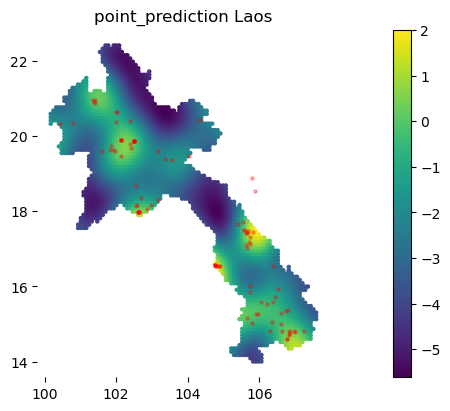

In [76]:
#Plot the predictions
fig, ax = plt.subplots()
model_lao_1_hsgp_idata_predictions_geo["point_prediction"].plot("point_prediction",legend=True, ax=ax,markersize =5)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_prediction Laos", );

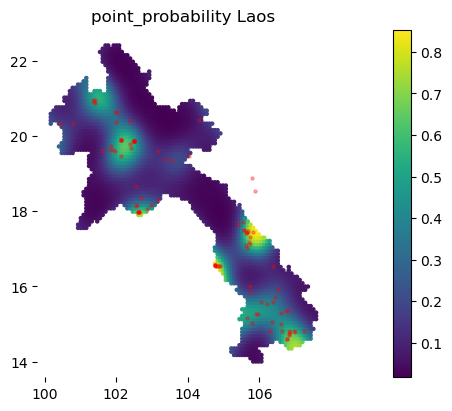

In [77]:
#Plot the predictions
fig, ax = plt.subplots()
model_lao_1_hsgp_idata_predictions_geo["point_probability"].plot("point_probability",legend=True, ax=ax,markersize =5)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_probability Laos", );

# Estimation for Laos only: Full model

In [78]:
#We define the map and the df for south east asia
laos_map = world.query('ISO_A3 == "LAO"')
lao_df = model_df_4.query('ISO == "LAO"')

#Tranform to geopandas df
lao_df = gpd.GeoDataFrame(lao_df,  geometry=gpd.points_from_xy(lao_df["long"],
                                lao_df["lat"]),crs="EPSG:4326")

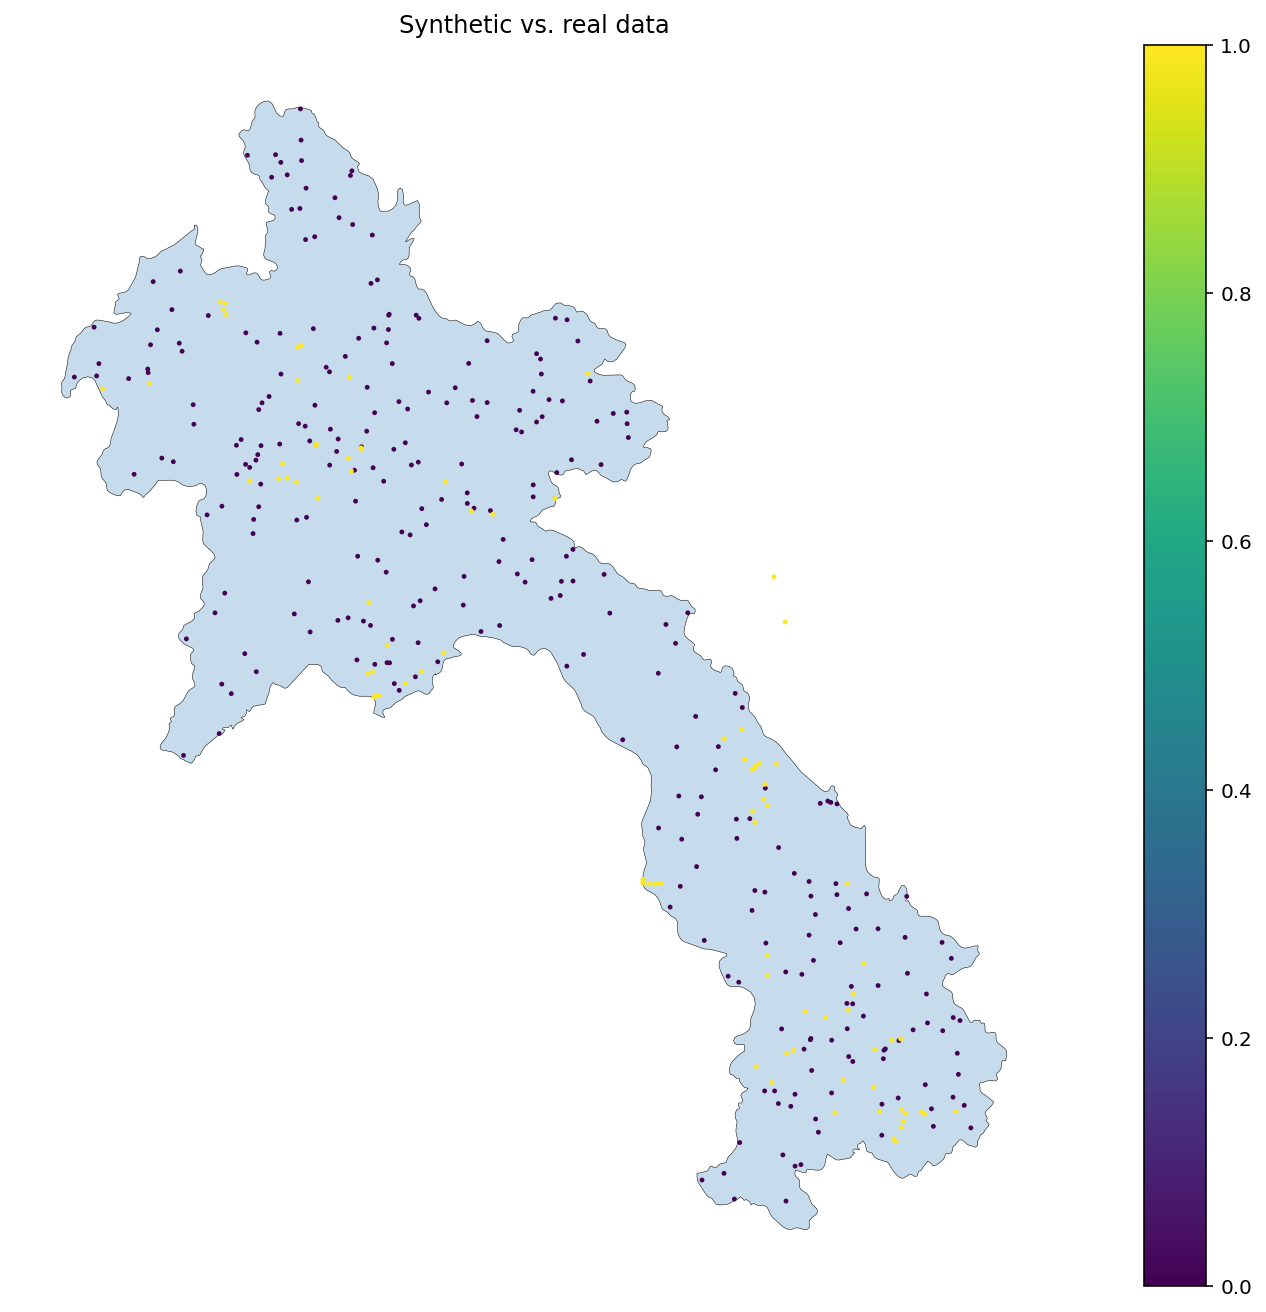

In [79]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
laos_map.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
laos_map.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)

lao_df.plot('is_disaster', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      # categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.title("Synthetic vs. real data")
plt.show()

In [80]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(lao_df["is_disaster"])
ISO_idx, ISO = pd.factorize(lao_df["ISO"]) 
obs_idx = lao_df.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(lao_df.set_index(['ISO', 'Start_Year']).index, 'obs_idx')


# Standardize data
transformer_stand_ =  Standardize().fit(lao_df)
lao_df_stand = transformer_stand_.transform(lao_df)

# Center the lat and long variables for the HSGP
transformer__center = CenterTransform().fit(lao_df[["lat", "long"]])
centered_HSGP_data = transformer__center.transform(lao_df[["lat", "long"]])

#Set coords
coords_lao = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_4_stand,
        "gp_feature":gp_features }

In [81]:
with pm.Model(coords=coords_lao) as model_lao_1_hsgp:
    #Declare data
    X, Y= add_data(features= features_4_stand ,  target = "is_disaster", df =  lao_df_stand, )
    is_island = pm.Data("is_island",  lao_df["is_island"].astype(bool), dims = ["obs_idx"] )
    
    # #Country effect
    # country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [0.1] * 10
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", centered_HSGP_data)

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2.0)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 15, 15, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))

    #Model mu
    p = (
        #country_effect[ISO_idx] + 
        (X * beta).sum(axis=1) + (is_island * is_island_beta) + HSGP_component)
    # p = HSGP_component
    

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [82]:
if exists("model_lao_full.idata"):
    model_lao_1_full_idata = az.from_netcdf("model_lao_full.idata")


else:
    compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(model_lao_1_hsgp), backend="jax", gradient_backend='jax')
    model_lao_1_full_idata = nutpie.sample(compiled_model)
    #Rename the is_island variable 
    model_lao_1_full_idata = model_lao_1_full_idata.rename({"'is_island'": "is_island_beta"})
    #Save the idata
    az.to_netcdf(data = model_lao_1_full_idata, filename= pathlib.Path("model_lao_full.idata"))

In [83]:
#Full model predictions
laos_grid_2d_basis = transformer__center.transform(laos_points[["lat", "lon"]].rename(columns = {"lon": "long"}))
laos_grid_2d = np.array(laos_grid_2d_basis)


with pm.Model(coords=coords_lao) as model_lao_1_hsgp_plot:
    #Declare data
    laos_is_island = laos_points["is_island"]
    laos_distances = transformer_stand_.transform(laos_points)[["log_distance_to_river__standardized", "log_distance_to_coastline__standardized"]]
    time_varying_features_2020 =(lao_df_stand[time_varying_features_4_stand].loc[18901,]).astype(float)

    #Flat variables
    is_island_beta = pm.Flat("is_island_beta")
    beta = pm.Flat("beta", dims = ["feature"])
    # country_effect = pm.Flat("country_effect", dims = ["ISO"])
    
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=laos_grid_2d)
    
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))
    
    
    point_prediction = pm.Deterministic("point_prediction", 
                             # country_effect[0] 
                             ( is_island_beta * laos_is_island) 
                            + (beta[0] * laos_distances["log_distance_to_river__standardized"] ) + (beta[1] * laos_distances["log_distance_to_coastline__standardized"])
                            + f_plot
                            +  (beta[2:] @ time_varying_features_2020 )
                              )
    
    point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

    model_lao_1_full_plot_idata = pm.sample_posterior_predictive(
        model_lao_1_full_idata, var_names= ["point_prediction", "point_probability"]
    )
    

Sampling: []


Output()

In [84]:
#Store df of predictions
model_lao_1_full_predictions = {}
model_lao_1_full_predictions_geo = {}

for x in ["point_prediction", "point_probability"]:
    
    model_lao_1_full_predictions[x] = (model_lao_1_full_plot_idata.posterior_predictive.mean(dim=("chain", "draw"))
                                   [x]
                                   .to_dataframe())
    
    #Merge predictions with Laos points
    model_lao_1_full_predictions[x] = pd.merge(model_lao_1_full_predictions[x], laos_points, 
                                           left_index=True, right_index=True,
                                           how = "left")
    
    #Transform into geo Data Frame
    model_lao_1_full_predictions_geo[x] = gpd.GeoDataFrame(
                    model_lao_1_full_predictions[x],
        geometry=gpd.points_from_xy(model_lao_1_full_predictions[x]["lon"],
                                    model_lao_1_full_predictions[x]["lat"]),crs="EPSG:4326"
                )

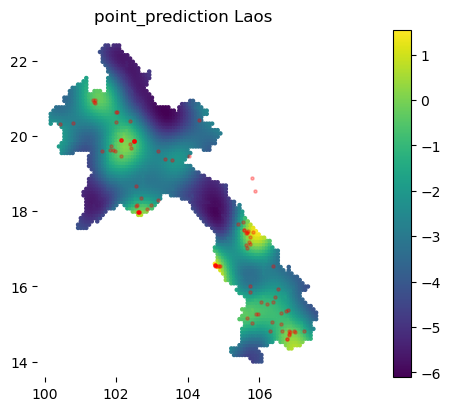

In [85]:
#Plot the predictions
fig, ax = plt.subplots()
model_lao_1_full_predictions_geo["point_prediction"].plot("point_prediction",legend=True, ax=ax,markersize =5)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_prediction Laos", );

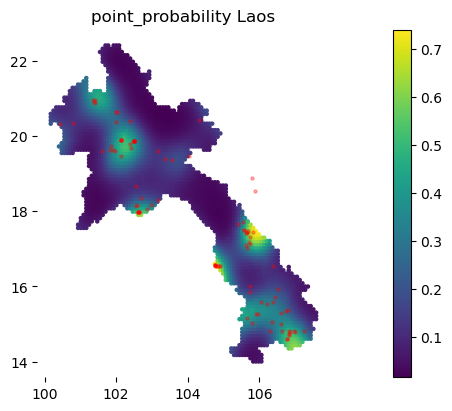

In [86]:
#Plot the predictions
fig, ax = plt.subplots()
model_lao_1_full_predictions_geo["point_probability"].plot("point_probability",legend=True, ax=ax,markersize =5)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_probability Laos", );